In [11]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import Pipeline 
import matplotlib as mpl
from sklearn.metrics import roc_auc_score

from heatmap import heatmap
from rfpimp import feature_dependence_matrix
from rfpimp import plot_dependence_heatmap
from rfpimp import PimpViz
# for the matplotlib styling
plt.style.use(['seaborn-bright', 'fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegressionCV

In [231]:
# Loading the data
data = pd.read_excel('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/loans/dataCOMP0050Coursework1.xlsx')
X = data.drop(columns = ['charged_off', 'issue_d'], axis=1)
y = data['charged_off']

# Determine categorical and numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Splitting on training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

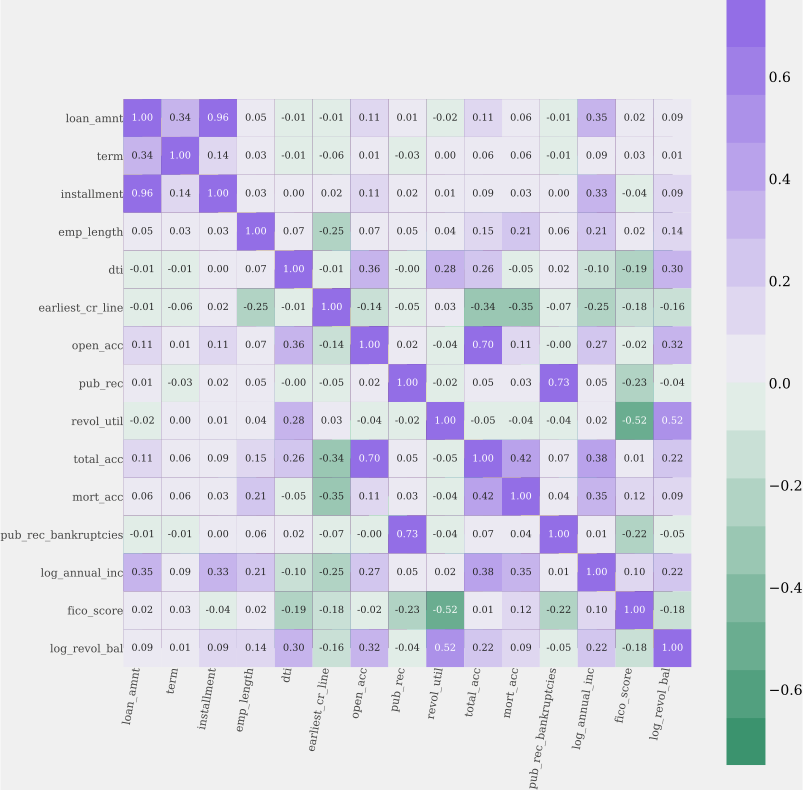

In [5]:
# Plotting the correlation matrix (Pearson)
GREY = '#444443'
plt.figure(figsize=(12,12))

sns.heatmap(X_train[numerical_cols].corr(),vmin=-0.75,vmax=0.75,center=0, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=16),annot=True, fmt='.2f', annot_kws ={'fontsize':'x-small'})
plt.tick_params(labelsize=11, labelcolor=GREY, pad=0)
plt.xticks(rotation=80, horizontalalignment='right', color=GREY)
plt.imshow(X_train[numerical_cols].corr(), vmax=1.0, vmin = 0,  aspect='equal')
plt.gcf().subplots_adjust(left=0.20, bottom=0.15)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/loans/artworks/corr_pearson.png')
PimpViz()

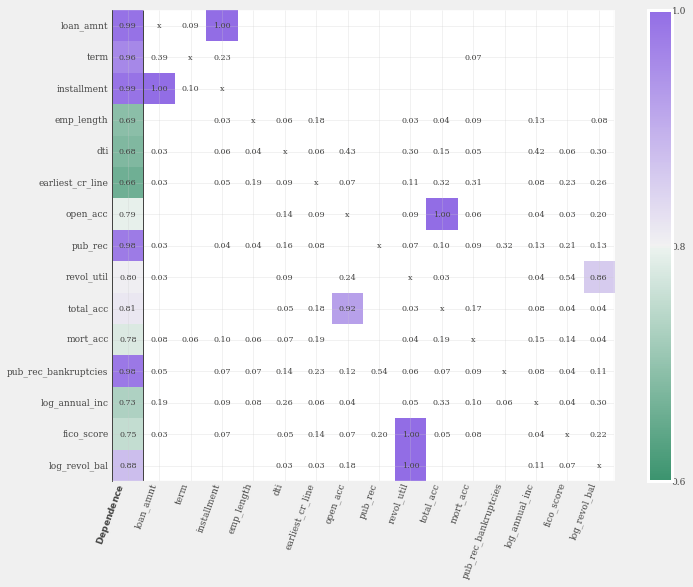

In [242]:
# Plotting the dependence heatmap
# Mean Imputing for the missing values
X_train['emp_length'].fillna(X_train['emp_length'].mean(), inplace=True)
X_train['revol_util'].fillna(X_train['revol_util'].mean(), inplace=True)
X_train['mort_acc'].fillna(X_train['mort_acc'].mean(), inplace=True)
X_train['pub_rec_bankruptcies'].fillna(X_train['pub_rec_bankruptcies'].mean(), inplace=True)

cw = sns.diverging_palette(150, 275, s=80, l=55, n=16, as_cmap=True)
cmap = ListedColormap([cw(x) for x in np.arange(0.1, 0.9, 0.01)])

dep = feature_dependence_matrix(X_train[numerical_cols])
plot_dependence_heatmap(dep, figsize = (10,8), cmap=cw)
plt.gcf().subplots_adjust(left=-0.20, bottom=0.15)
# PimpViz()
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/loans/artworks/dep2.png')



In [9]:
# Building (data preprocessing pipeline) the column transformer 
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

col_transform = ColumnTransformer([
    ('cat', categorical_transformer, categorical_cols),
    ('num', num_pipeline, numerical_cols)
])
over = SMOTENC(categorical_features=[X_train.dtypes==object],sampling_strategy=0.3)
# X_train, y_train = over.fit_resample(X_train, y_train)

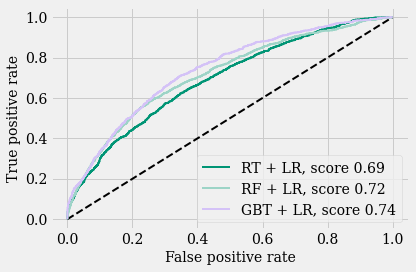

In [220]:
# Using embedding models: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,stratify=y)

# Preprocessing the data
train_pipeline = Pipeline(steps=[
    ('preprocessing', col_transform),
    ('over', over)])
X_train, y_train = train_pipeline.fit_resample(X_train, y_train)

test_pipeline = Pipeline(steps=[
    ('preprocessing', col_transform)])

X_test, y_test = train_pipeline.fit_resample(X_test, y_test)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5,stratify=y_train)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=50,
                          random_state=0)

rt_lm = LogisticRegressionCV(max_iter=10000, cv=5, solver='lbfgs', scoring='roc_auc')
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50, oob_score=True,max_features='sqrt')
rf_enc = OneHotEncoder()
rf_lm = LogisticRegressionCV(max_iter=10000, cv=5, solver='lbfgs', scoring='roc_auc')
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=50)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegressionCV(max_iter=1000, cv=5, solver='lbfgs', scoring='roc_auc')
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)




with sns.diverging_palette(160, 275, s=100, l=55, n=4):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR, score {:0.2f}'.format(roc_auc_score(y_test,y_pred_rt)))
    plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR, score {:0.2f}'.format(roc_auc_score(y_test,y_pred_rf_lm)))
    plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR, score {:0.2f}'.format(roc_auc_score(y_test,y_pred_grd_lm)))
    plt.xlabel('False positive rate', {'fontsize':'medium'})
    plt.ylabel('True positive rate', {'fontsize':'medium'})
    plt.legend(loc='best', fancybox=True, frameon=True)
    PimpViz()
    plt.savefig('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/loans/artworks/embeddings1.png')


In [229]:
# Report of the results of embedded models: Decision Tree
print(classification_report(y_test, pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      3804
           1       0.55      0.18      0.27      1141

    accuracy                           0.78      4945
   macro avg       0.67      0.57      0.57      4945
weighted avg       0.74      0.78      0.73      4945



In [227]:
# Report of the results of embedded models: Random Forest
print(classification_report(y_test, rf_lm.predict(rf_enc.transform(rf.apply(X_test)))))

              precision    recall  f1-score   support

           0       0.87      0.64      0.73      3804
           1       0.36      0.68      0.47      1141

    accuracy                           0.65      4945
   macro avg       0.61      0.66      0.60      4945
weighted avg       0.75      0.65      0.67      4945



In [228]:
# Report of the results of embedded models: Gradient Boosting
print(classification_report(y_test, grd_lm.predict(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))))

              precision    recall  f1-score   support

           0       0.89      0.58      0.71      3804
           1       0.35      0.76      0.48      1141

    accuracy                           0.63      4945
   macro avg       0.62      0.67      0.60      4945
weighted avg       0.77      0.63      0.65      4945



In [25]:
# Logistic regression 
model_pipeline = Pipeline([
    ('preprocessing', col_transform),
    ('over', over),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000)) 
])

param = {
    'classifier__C': [1e-4, 1e-2, 1e-1, 1.001, 3.001, 10, 30, 100, 300, 1000, 3000, 10000]
}
logit = GridSearchCV(estimator=model_pipeline, param_grid=param, cv=10, scoring = 'recall_macro').fit(X_train, y_train)
logit.score(X_test,y_test) #Recall_macro
logit_predict = logit.predict_proba(X_test)[:, 1]
fpr_logit, tpr_logit, _ = roc_curve(y_test, logit_predict)


In [243]:
logit.best_params_

{'classifier__C': 3.001}

In [194]:
print(classification_report(y_test, logit.predict(X_test)))


              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3044
           1       0.38      0.13      0.19       528

    accuracy                           0.84      3572
   macro avg       0.62      0.55      0.55      3572
weighted avg       0.79      0.84      0.81      3572



In [197]:
# Decision Tree
from sklearn.pipeline import make_pipeline
tree_pipeline = Pipeline([
    ('preprocessing', col_transform),
    ('over', over),
    ('classifier', DecisionTreeClassifier(ccp_alpha=0.0006, max_depth=3, min_samples_split=3 )) 
])
# params = {
#     'max_depth':range(1,10),
#     'min_samples_split':range(1,10),
#     'min_samples_leaf': range(1,10)
# }

grid_tree = tree_pipeline.fit(X_train, y_train)
grid_tree.score(X_test,y_test)
tree_y_predict = grid_tree.predict_proba(X_test)[:, 1]
fpr_tree_y, tpr_tree_y, _ = roc_curve(y_test, tree_y_predict)

In [198]:
print(classification_report(y_test, grid_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      3044
           1       0.22      0.03      0.05       528

    accuracy                           0.84      3572
   macro avg       0.54      0.51      0.48      3572
weighted avg       0.76      0.84      0.79      3572



In [58]:
# Random Forests 
forest_pipeline = Pipeline([
    ('preprocessing', col_transform),
    ('over', over),
    ('decision', RandomForestClassifier())
])
cv = StratifiedKFold(n_splits=10, random_state=None)
grid_params_rf = [{'decision__criterion': ['gini', 'entropy'],
                   'decision__max_depth': [7],
                   'decision__min_samples_split': [5],
                   'decision__n_estimators': [100, 200, 300, 500,600, 1000],
                   'decision__max_features': ['auto']}]
grid_forest = GridSearchCV(forest_pipeline, param_grid=grid_params_rf, cv=5, verbose=1, n_jobs=-1, scoring='recall_macro').fit(X_train, y_train)
grid_forest.score(X_test,y_test)
forest_y_predict = grid_forest.predict_proba(X_test)[:, 1]
fpr_forest_y, tpr_forest_y, _ = roc_curve(y_test, forest_y_predict)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [245]:
print(classification_report(y_test, grid_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      3044
           1       0.43      0.03      0.05       528

    accuracy                           0.85      3572
   macro avg       0.64      0.51      0.49      3572
weighted avg       0.79      0.85      0.79      3572



In [244]:
grid_forest.best_params_

{'decision__criterion': 'gini',
 'decision__max_depth': 7,
 'decision__max_features': 'auto',
 'decision__min_samples_split': 5,
 'decision__n_estimators': 500}

In [202]:
# Gradient Boosting with CatBoost
from catboost import CatBoostClassifier, Pool, cv
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
boosting = CatBoostClassifier(
    iterations=1000,
    custom_loss=['F1'],
    random_seed=42,
    logging_level='Silent',
    train_dir='model_depth_1/'
)

boosting.fit(
    X_train1, y_train1,
    cat_features=categorical_cols,
    eval_set=(X_test1, y_test1),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=False
)

boosting_y_predict = boosting.predict_proba(X_test1)[:, 1]
fpr_boosting_y, tpr_boosting_y, _ = roc_curve(y_test1, boosting_y_predict)


: 0.3863226 (110)	total: 5.25s	remaining: 1.49s
779:	learn: 0.1961623	test: 0.4083994	best: 0.3863226 (110)	total: 5.26s	remaining: 1.48s
780:	learn: 0.1960313	test: 0.4084548	best: 0.3863226 (110)	total: 5.27s	remaining: 1.48s
781:	learn: 0.1959209	test: 0.4084105	best: 0.3863226 (110)	total: 5.27s	remaining: 1.47s
782:	learn: 0.1957513	test: 0.4084181	best: 0.3863226 (110)	total: 5.28s	remaining: 1.46s
783:	learn: 0.1955528	test: 0.4085226	best: 0.3863226 (110)	total: 5.28s	remaining: 1.46s
784:	learn: 0.1952217	test: 0.4086300	best: 0.3863226 (110)	total: 5.29s	remaining: 1.45s
785:	learn: 0.1950959	test: 0.4086057	best: 0.3863226 (110)	total: 5.29s	remaining: 1.44s
786:	learn: 0.1949400	test: 0.4086540	best: 0.3863226 (110)	total: 5.3s	remaining: 1.43s
787:	learn: 0.1945991	test: 0.4084625	best: 0.3863226 (110)	total: 5.3s	remaining: 1.43s
788:	learn: 0.1944323	test: 0.4084769	best: 0.3863226 (110)	total: 5.31s	remaining: 1.42s
789:	learn: 0.1942482	test: 0.4084952	best: 0.3863226 

In [204]:
print(classification_report(y_test, boosting.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3044
           1       0.57      0.02      0.04       528

    accuracy                           0.85      3572
   macro avg       0.71      0.51      0.48      3572
weighted avg       0.81      0.85      0.79      3572



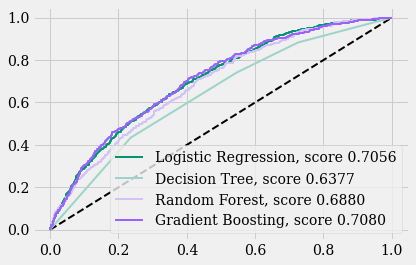

In [74]:
with sns.diverging_palette(160, 275, s=100, l=55, n=4):
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_logit, tpr_logit, label='Logistic Regression, score {:0.4f}'.format(roc_auc_score(y_test,logit_predict)))
    plt.plot(fpr_tree_y, tpr_tree_y, label='Decision Tree, score {:0.4f}'.format(roc_auc_score(y_test,tree_y_predict)))
    plt.plot(fpr_forest_y, tpr_forest_y, label='Random Forest, score {:0.4f}'.format(roc_auc_score(y_test,forest_y_predict)))
    plt.plot(fpr_boosting_y, tpr_boosting_y, label='Gradient Boosting, score {:0.4f}'.format(roc_auc_score(y_test1,boosting_y_predict)))
    plt.legend(loc='best', fancybox=True, frameon=True)
    plt.savefig('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/loans/artworks/models.png')

In [169]:
# Future Importance on Random Forests
from sklearn.preprocessing import OrdinalEncoder
from rfpimp import permutation_importances
from rfpimp import oob_classifier_accuracy

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Building (data preprocessing pipeline) the column transformer 
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorical_transformer = Pipeline([('ordinal', OrdinalEncoder(handle_unknown='error'))])

col_transform = ColumnTransformer([
    ('cat', categorical_transformer, categorical_cols),
    ('num', num_pipeline, numerical_cols)
])
over = SMOTENC(categorical_features=[X_train.dtypes==object],sampling_strategy=0.3)

feature_pipeline = Pipeline([
    ('preprocessing', col_transform),
    ('over', over)
])
X_traines, y_traines = feature_pipeline.fit_resample(X_train,y_train)
# Training the model
rf = RandomForestClassifier(max_depth=7, max_features='sqrt',min_samples_split= 5,n_estimators=50, oob_score=True)
rf.fit(X_traines, y_traines)

In [173]:
imp = permutation_importances(rf, pd.DataFrame(X_traines), pd.DataFrame(y_traines),
                              oob_classifier_accuracy)

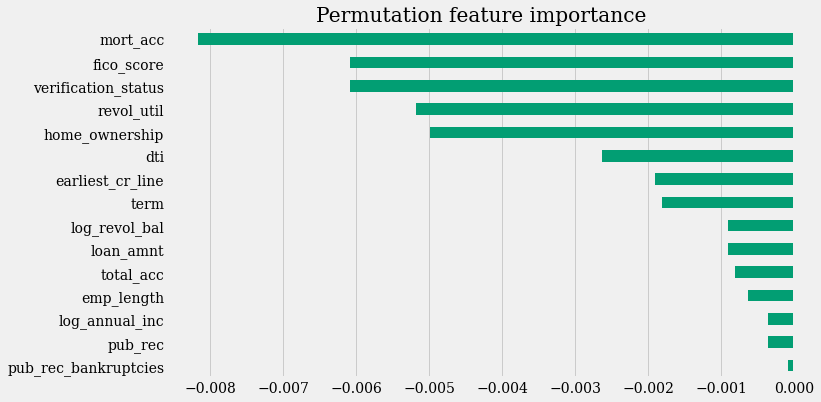

In [187]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)
imp = permutation_importances(rf, pd.DataFrame(X_traines), pd.DataFrame(y_traines),
                              oob_classifier_accuracy)

features = ['home_ownership', 'verification_status', 'application_type', 'loan_amnt', 'term', 'emp_length', 'dti', 'earliest_cr_line', 'pub_rec',
       'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies',
        'log_annual_inc', 'fico_score', 'log_revol_bal']


df_imp = pd.Series(imp, index=features)
# df_imp = pd.Series(imp)
sns_colors = sns.color_palette('colorblind')

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-15:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()